In [84]:
import mesa
import random
import matplotlib.pyplot as plt
import pandas as pd

# Homogeninization of creativity


In [85]:
class HumanAgent(mesa.Agent):
    """
    An agent that represents a human actor generating ideas.
    """
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.memory = set()
        self.unique_id = unique_id
    def create_ideas(self, num_ideas_to_create, idea_pool):
        """
        Human agent generates a specified number of ideas.
        50% from AI suggestions (if available), 50% self-created.
        Of self-created: 80% from memory, 20% new from pool.
        """
        newly_generated_ideas = set()

        # Ideas from AI (50% of num_ideas_to_create)
        num_from_ai = num_ideas_to_create // 2
        ai_suggestions = self.model.ai_agent.propose_ideas(num_from_ai)
        newly_generated_ideas.update(ai_suggestions)

        # Self created ideas (remaining 50%)
        num_self_created = num_ideas_to_create - num_from_ai
        num_from_memory = int(num_self_created * 0.8)
        num_new_from_pool = num_self_created - num_from_memory

        # 80% from memory
        if self.memory:
            ideas_from_memory = random.sample(list(self.memory), min(num_from_memory, len(self.memory)))
            newly_generated_ideas.update(ideas_from_memory)

        # 20% new from idea pool
        available_new_ideas = list(idea_pool - self.memory - newly_generated_ideas)
        if available_new_ideas:
            new_ideas = random.sample(available_new_ideas, min(num_new_from_pool, len(available_new_ideas)))
            newly_generated_ideas.update(new_ideas)
        
        self.memory.update(newly_generated_ideas) # Add newly generated ideas to memory
        return newly_generated_ideas

    def step(self):
        pass

In [86]:
class AIAgent(mesa.Agent):
    """
    An agent that represents an AI with no memory loss of ideas.
    """
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.eternal_memory = {}
        self.unique_id = unique_id

    def receive_ideas(self, ideas):
        """
        AI receives ideas and updates its eternal memory with their frequency.
        """
        for idea in ideas:
            self.eternal_memory[idea] = self.eternal_memory.get(idea, 0) + 1

    def propose_ideas(self, num_ideas_to_propose):
        """
        AI proposes ideas from its memory based on frequency.
        Simplified: top N most frequently submitted ideas.
        """
        if not self.eternal_memory:
            return set()

        # Sort ideas by frequency in descending order
        sorted_ideas = sorted(self.eternal_memory.items(), key=lambda item: item[1], reverse=True)
        
        # Take the top N ideas
        proposed_ideas = set()
        for idea, _ in sorted_ideas:
            proposed_ideas.add(idea)
            if len(proposed_ideas) >= num_ideas_to_propose:
                break
        return proposed_ideas

In [87]:
class HomogenizationModel(mesa.Model):
    """
    Simulating idea generation with human actors and an AI.
    Manually manages agent activation order.
    """
    def __init__(self, num_human_agents=25, total_idea_pool_size=500, initial_ideas_per_actor=(5, 50)):
        super().__init__()
        self._agents = {} 
        self.num_human_agents = num_human_agents
        self.total_idea_pool_size = total_idea_pool_size
        self.initial_ideas_per_actor = initial_ideas_per_actor
        
        self.all_model_agents = [] # List to hold all agents (renamed from self.agents)
        self.current_step = 0 # Track current simulation step

        self.idea_pool = set([f"idea_{i}" for i in range(total_idea_pool_size)])
        self.all_ideas_generated_in_round = set() # Ideas generated by all humans in the previous round

        # Create AI Agent
        self.ai_agent = AIAgent("AI", self)
        self.all_model_agents.append(self.ai_agent) # Add AI to the general agents list

        # Create Human Agents
        for i in range(self.num_human_agents):
            human_agent = HumanAgent(i, self)
            self.all_model_agents.append(human_agent) # Add human agent to the general agents list

        # Data collector to track model-level variables
        self.datacollector = mesa.DataCollector(
            model_reporters= {"HomogenizationIndex": self.calculate_homogenization},
            agent_reporters={"MemorySize": lambda a: len(a.memory) if isinstance(a, HumanAgent) else 0}
        )
        
        self.running = True

        # Step 0: Initial idea generation
        print("Step 0: Initial Idea Generation")
        self.initial_idea_generation()
        self.all_ideas_generated_in_round.clear() # Clear for next step's collection

    def initial_idea_generation(self):
        """
        Initial idea generation phase for all human agents (Step 0).
        """
        human_agents = [agent for agent in self.all_model_agents if isinstance(agent, HumanAgent)]
        for agent in human_agents:
            num_ideas = random.randint(self.initial_ideas_per_actor[0], self.initial_ideas_per_actor[1])
            initial_ideas = random.sample(list(self.idea_pool), min(num_ideas, len(self.idea_pool)))
            agent.memory.update(initial_ideas)
            self.all_ideas_generated_in_round.update(initial_ideas)
        
        # All ideas generated in Step 0 are fed into the AI
        self.ai_agent.receive_ideas(self.all_ideas_generated_in_round)
        print(f"Total unique ideas after Step 0: {len(self.all_ideas_generated_in_round)}")
        print(f"AI memory size after Step 0: {len(self.ai_agent.eternal_memory)}")

    def calculate_homogenization(self):
        """
        Calculates a simple homogenization index based on the overlap of ideas.
        """
        human_agents = [agent for agent in self.all_model_agents if isinstance(agent, HumanAgent)]
        if not human_agents:
            return 0
        
        idea_counts = {}
        for agent in human_agents:
            for idea in agent.memory:
                idea_counts[idea] = idea_counts.get(idea, 0) + 1
        
        if not idea_counts:
            return 0

        total_ideas_in_memories = sum(len(a.memory) for a in human_agents)
        unique_ideas_in_memories = len(self.get_all_human_ideas())

        if total_ideas_in_memories == 0:
            return 0

        # A higher value means more ideas are shared across agents, implying homogenization.
        return 1 - (unique_ideas_in_memories / total_ideas_in_memories)

    def get_all_human_ideas(self):
        """Collects all unique ideas currently held in human agents' memories."""
        all_human_ideas = set()
        for agent in self.all_model_agents:
            if isinstance(agent, HumanAgent):
                all_human_ideas.update(agent.memory)
        return all_human_ideas

    def step(self):
        """
        Run one step of the simulation (Step 1 of the document),
        managing agent activation manually.
        """
        self.current_step += 1 
        self.all_ideas_generated_in_round.clear() # Reset for the current step's collection

        # Get only human agents and shuffle them for random activation
        human_agents_for_current_round = [agent for agent in self.all_model_agents if isinstance(agent, HumanAgent)]
        random.shuffle(human_agents_for_current_round)

        current_round_ideas_from_all_humans = set() # Collects ideas generated by all humans in this step

        # Each human agent generates new ideas in a random order
        for agent in human_agents_for_current_round:
            num_ideas_to_create = random.randint(self.initial_ideas_per_actor[0], self.initial_ideas_per_actor[1])
            new_ideas_by_this_agent = agent.create_ideas(num_ideas_to_create, self.idea_pool)
            current_round_ideas_from_all_humans.update(new_ideas_by_this_agent)

        # All ideas generated in this round by actors get fed into the AI
        self.ai_agent.receive_ideas(current_round_ideas_from_all_humans)
        self.all_ideas_generated_in_round = current_round_ideas_from_all_humans # Update for metrics/next round

        self.datacollector.collect(self)
        print(f"Step {self.current_step}: Total unique ideas generated this round: {len(self.all_ideas_generated_in_round)}")
        print(f"AI memory size: {len(self.ai_agent.eternal_memory)}")
        print(f"Homogenization Index: {self.calculate_homogenization():.4f}")


In [88]:

model = HomogenizationModel(num_human_agents=25, total_idea_pool_size=500)

for i in range(300): # Run 50 steps after initial generation
    model.step()


model_df = model.datacollector.get_model_vars_dataframe()
print("\nModel-level data:")
print(model_df)

Step 0: Initial Idea Generation
Total unique ideas after Step 0: 401
AI memory size after Step 0: 401
Step 1: Total unique ideas generated this round: 249
AI memory size: 417
Homogenization Index: 0.6283
Step 2: Total unique ideas generated this round: 265
AI memory size: 433
Homogenization Index: 0.6749
Step 3: Total unique ideas generated this round: 187
AI memory size: 441
Homogenization Index: 0.6877
Step 4: Total unique ideas generated this round: 197
AI memory size: 447
Homogenization Index: 0.7032
Step 5: Total unique ideas generated this round: 195
AI memory size: 453
Homogenization Index: 0.7151
Step 6: Total unique ideas generated this round: 235
AI memory size: 462
Homogenization Index: 0.7278
Step 7: Total unique ideas generated this round: 207
AI memory size: 466
Homogenization Index: 0.7385
Step 8: Total unique ideas generated this round: 239
AI memory size: 470
Homogenization Index: 0.7484
Step 9: Total unique ideas generated this round: 236
AI memory size: 478
Homogeniz

Bar plot of top 50 ideas saved as 'top_popular_ideas.png'


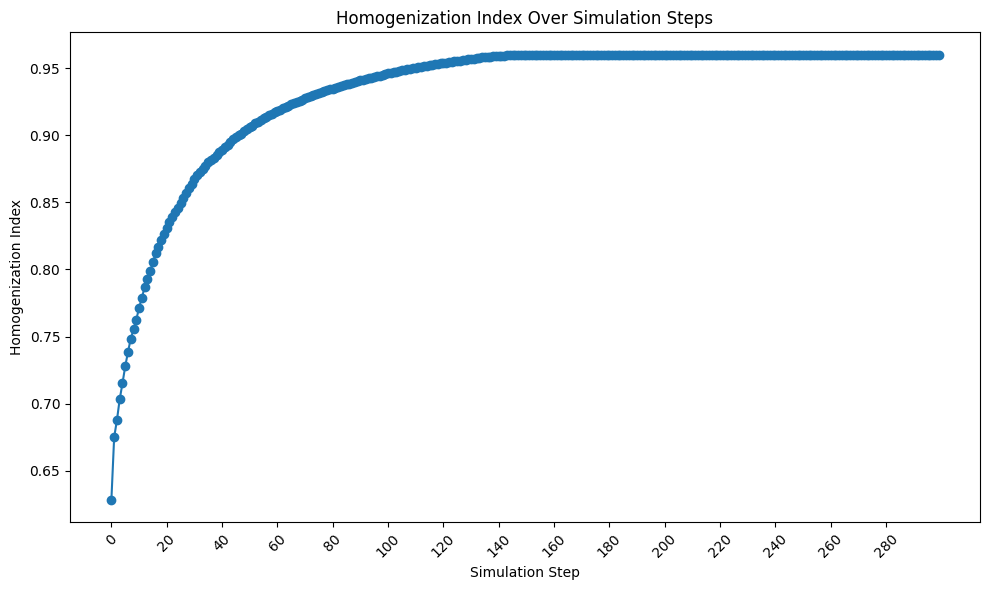

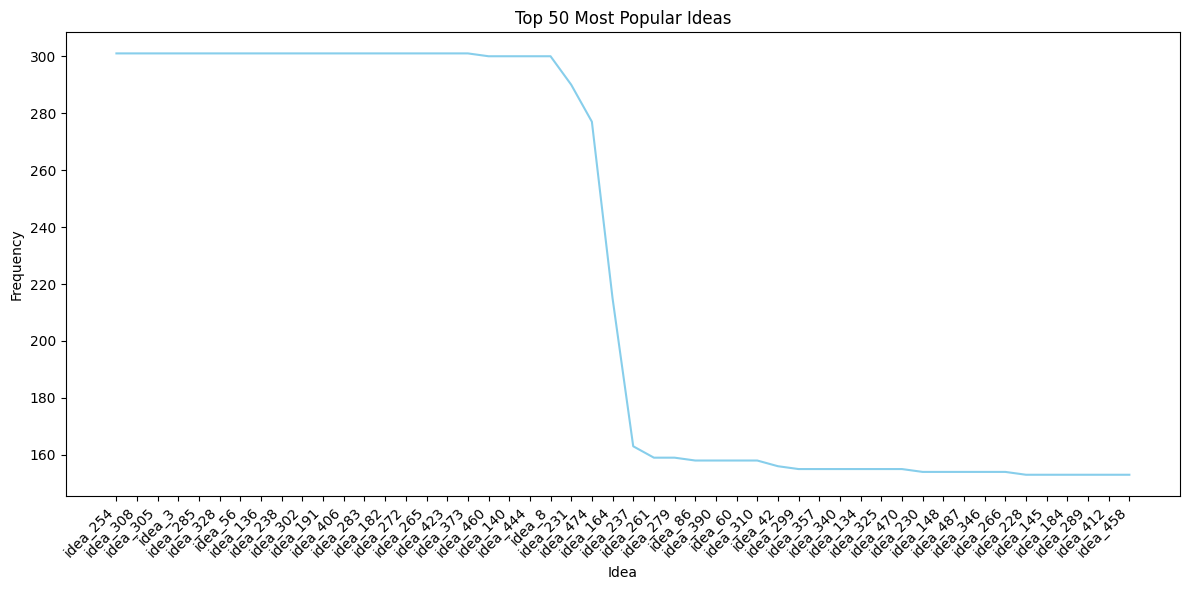

In [89]:

plt.figure(figsize=(10, 6))
plt.plot(model_df.index, model_df['HomogenizationIndex'], marker='o')
plt.title('Homogenization Index Over Simulation Steps')
plt.xlabel('Simulation Step')
plt.ylabel('Homogenization Index')
plt.grid(False)
step = 20
plt.xticks(model_df.index[::step], rotation=45)
plt.tight_layout()


N = 50
top_ideas = sorted(model.ai_agent.eternal_memory.items(), key=lambda x: x[1], reverse=True)[:N]
ideas, counts = zip(*top_ideas) if top_ideas else ([], [])

plt.figure(figsize=(12, 6))
plt.plot(ideas, counts, color='skyblue')
plt.title(f'Top {N} Most Popular Ideas')
plt.xlabel('Idea')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
print(f"Bar plot of top {N} ideas saved as 'top_popular_ideas.png'")
